# Safe Land Rwanda - Neighborhood Real Estate Valuation & Market Insights Engine

## Overview
This comprehensive notebook builds an AI-powered real estate valuation system for Rwanda land transactions. It includes:
- **Data Cleaning & Feature Engineering**: Prepare and engineer features from raw transaction data
- **Market Trend Analysis**: Identify investment opportunities through trend analysis
- **Geospatial Visualization**: Interactive maps showing property locations and prices
- **ML Model**: Random Forest Regressor for accurate price predictions
- **Model Persistence**: Save trained model for deployment

### Dataset Schema
**Columns**: provincename, districtname, sectorname, cellname, village, upi, size, land_use_name_kinyarwanda, transaction_type_name, sale_price, start_date, latitude, longitude, polygon_wkt

## Step 1: Import Required Libraries

In [1]:
# Essential Data Processing & Analysis Libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Geospatial Libraries
import folium
from folium import plugins
import plotly.express as px
import plotly.graph_objects as go

# Model Persistence
import pickle

# Utilities
from datetime import datetime
import os

# Set style for visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✓ All libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 2.1.3


## Step 2: Load and Explore the Dataset

In [2]:
# Load the Rwanda land transaction dataset
# NOTE: Replace 'your_data.csv' with the actual path to your dataset
# For demo purposes, we'll create sample data if file doesn't exist

data_path = 'safe_land_rwanda_transactions.csv'

# Check if data file exists; if not, create sample data for demonstration
if not os.path.exists(data_path):
    print("Creating sample dataset for demonstration...")
    np.random.seed(42)
    
    provinces = ['Eastern', 'Western', 'Northern', 'Southern', 'Kigali']
    districts = ['Bugesera', 'Gatsibo', 'Nyaruguru', 'Nyamasheke', 'Musanze', 
                 'Gicumbi', 'Gisagara', 'Nyamagabe', 'Kicukiro', 'Gasabo']
    sectors = ['Gashora', 'Ngarama', 'Nyakabanda', 'Mushwere', 'Ruhengeri']
    cells = ['Biryogo', 'Mukarange', 'Kaduha', 'Giharo', 'Nyabihu']
    land_uses = ['Gutura', 'Umurimo', 'Ingano', 'Imyidyo']
    
    sample_data = {
        'provincename': np.random.choice(provinces, 500),
        'districtname': np.random.choice(districts, 500),
        'sectorname': np.random.choice(sectors, 500),
        'cellname': np.random.choice(cells, 500),
        'village': ['Village_' + str(i) for i in range(1, 501)],
        'upi': ['UPI_' + str(i) for i in range(1, 501)],
        'size': np.random.randint(200, 5000, 500),
        'land_use_name_kinyarwanda': np.random.choice(land_uses, 500),
        'transaction_type_name': np.random.choice(['Transfer by Voluntary Sale', 'Sale', 'Inheritance'], 500),
        'sale_price': np.random.randint(500000, 10000000, 500),
        'start_date': pd.date_range('2020-01-01', periods=500, freq='D'),
        'latitude': np.random.uniform(-2.5, -1.0, 500),
        'longitude': np.random.uniform(29.0, 31.0, 500),
        'polygon_wkt': ['POLYGON((0 0, 1 0, 1 1, 0 1, 0 0))'] * 500
    }
    
    df_raw = pd.DataFrame(sample_data)
    df_raw.to_csv(data_path, index=False)
    print(f"✓ Sample dataset created and saved to {data_path}")
else:
    df_raw = pd.read_csv(data_path)

# Display basic information about the dataset
print("\n" + "="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"\nDataset Shape: {df_raw.shape}")
print(f"\nData Types:\n{df_raw.dtypes}")
print(f"\nMissing Values:\n{df_raw.isnull().sum()}")
print(f"\nFirst 5 Rows:")
print(df_raw.head())
print(f"\nBasic Statistics:")
print(df_raw.describe())

Creating sample dataset for demonstration...
✓ Sample dataset created and saved to safe_land_rwanda_transactions.csv

DATASET OVERVIEW

Dataset Shape: (500, 14)

Data Types:
provincename                         object
districtname                         object
sectorname                           object
cellname                             object
village                              object
upi                                  object
size                                  int64
land_use_name_kinyarwanda            object
transaction_type_name                object
sale_price                            int64
start_date                   datetime64[ns]
latitude                            float64
longitude                           float64
polygon_wkt                          object
dtype: object

Missing Values:
provincename                 0
districtname                 0
sectorname                   0
cellname                     0
village                      0
upi                     

## Step 3: Data Cleaning & Feature Engineering

This is a crucial step that prepares the data for modeling. We will:
1. Filter for "Transfer by Voluntary Sale" transactions
2. Create temporal features (year, month, quarter)
3. Calculate price per square meter (price_per_sqm)
4. Remove outliers (top/bottom 5%)
5. Create neighborhood encoding (cell_avg_price)

In [3]:
# Create a copy for processing
df = df_raw.copy()

print("="*80)
print("DATA CLEANING & FEATURE ENGINEERING")
print("="*80)

# Step 1: Filter for "Transfer by Voluntary Sale" transactions only
print("\n1. Filtering for 'Transfer by Voluntary Sale' transactions...")
initial_count = len(df)
df = df[df['transaction_type_name'] == 'Transfer by Voluntary Sale'].copy()
filtered_count = len(df)
print(f"   Initial records: {initial_count}")
print(f"   Records after filter: {filtered_count}")
print(f"   Records removed: {initial_count - filtered_count}")

# Step 2: Convert start_date to datetime and extract temporal features
print("\n2. Creating temporal features...")
df['start_date'] = pd.to_datetime(df['start_date'])
df['transaction_year'] = df['start_date'].dt.year
df['transaction_month'] = df['start_date'].dt.month
df['quarter'] = df['start_date'].dt.quarter
print(f"   ✓ Added: transaction_year, transaction_month, quarter")
print(f"   Date range: {df['start_date'].min()} to {df['start_date'].max()}")

# Step 3: Calculate price per square meter (valuation metric)
print("\n3. Creating valuation metric (price_per_sqm)...")
df['price_per_sqm'] = df['sale_price'] / df['size']
print(f"   ✓ price_per_sqm calculated")
print(f"   Price per sqm range: {df['price_per_sqm'].min():.2f} to {df['price_per_sqm'].max():.2f}")

# Step 4: Remove outliers (top 5% and bottom 5%)
print("\n4. Removing outliers (top/bottom 5% of price_per_sqm)...")
before_outlier_removal = len(df)
Q1 = df['price_per_sqm'].quantile(0.05)
Q3 = df['price_per_sqm'].quantile(0.95)
df = df[(df['price_per_sqm'] >= Q1) & (df['price_per_sqm'] <= Q3)]
after_outlier_removal = len(df)
print(f"   Outlier range: < {Q1:.2f} or > {Q3:.2f}")
print(f"   Records before: {before_outlier_removal}")
print(f"   Records after: {after_outlier_removal}")
print(f"   Records removed: {before_outlier_removal - after_outlier_removal}")

# Step 5: Create neighborhood encoding (cell_avg_price)
# This is CRUCIAL - it teaches the model the intrinsic value of each neighborhood
print("\n5. Creating neighborhood encoding (cell_avg_price)...")
cell_price_mapping = df.groupby('cellname')['price_per_sqm'].mean().to_dict()
df['cell_avg_price'] = df['cellname'].map(cell_price_mapping)
print(f"   ✓ Unique neighborhoods: {len(cell_price_mapping)}")
print(f"   Sample neighborhood values:")
for cell, price in list(cell_price_mapping.items())[:5]:
    print(f"      {cell}: {price:.2f} RWF/sqm")

print("\n" + "="*80)
print(f"FINAL CLEANED DATASET: {len(df)} records, {len(df.columns)} columns")
print("="*80)
print(f"\nFinal columns: {list(df.columns)}")

DATA CLEANING & FEATURE ENGINEERING

1. Filtering for 'Transfer by Voluntary Sale' transactions...
   Initial records: 500
   Records after filter: 177
   Records removed: 323

2. Creating temporal features...
   ✓ Added: transaction_year, transaction_month, quarter
   Date range: 2020-01-05 00:00:00 to 2021-05-10 00:00:00

3. Creating valuation metric (price_per_sqm)...
   ✓ price_per_sqm calculated
   Price per sqm range: 120.50 to 21063.19

4. Removing outliers (top/bottom 5% of price_per_sqm)...
   Outlier range: < 462.97 or > 12900.47
   Records before: 177
   Records after: 159
   Records removed: 18

5. Creating neighborhood encoding (cell_avg_price)...
   ✓ Unique neighborhoods: 5
   Sample neighborhood values:
      Biryogo: 2453.19 RWF/sqm
      Giharo: 3994.10 RWF/sqm
      Kaduha: 3614.07 RWF/sqm
      Mukarange: 2855.38 RWF/sqm
      Nyabihu: 2861.18 RWF/sqm

FINAL CLEANED DATASET: 159 records, 19 columns

Final columns: ['provincename', 'districtname', 'sectorname', 'cell

## Step 4: Market Trend Analysis & Insights

Analyze trends to identify investment opportunities:


TREND 1: TEMPORAL PRICE TRENDS

Price per sqm by Year and Quarter:
   transaction_year  quarter  price_per_sqm year_quarter
0              2020        1    2696.743672      2020-Q1
1              2020        2    2795.081720      2020-Q2
2              2020        3    3236.794271      2020-Q3
3              2020        4    3297.710018      2020-Q4
4              2021        1    3954.023416      2021-Q1
5              2021        2    3090.371220      2021-Q2


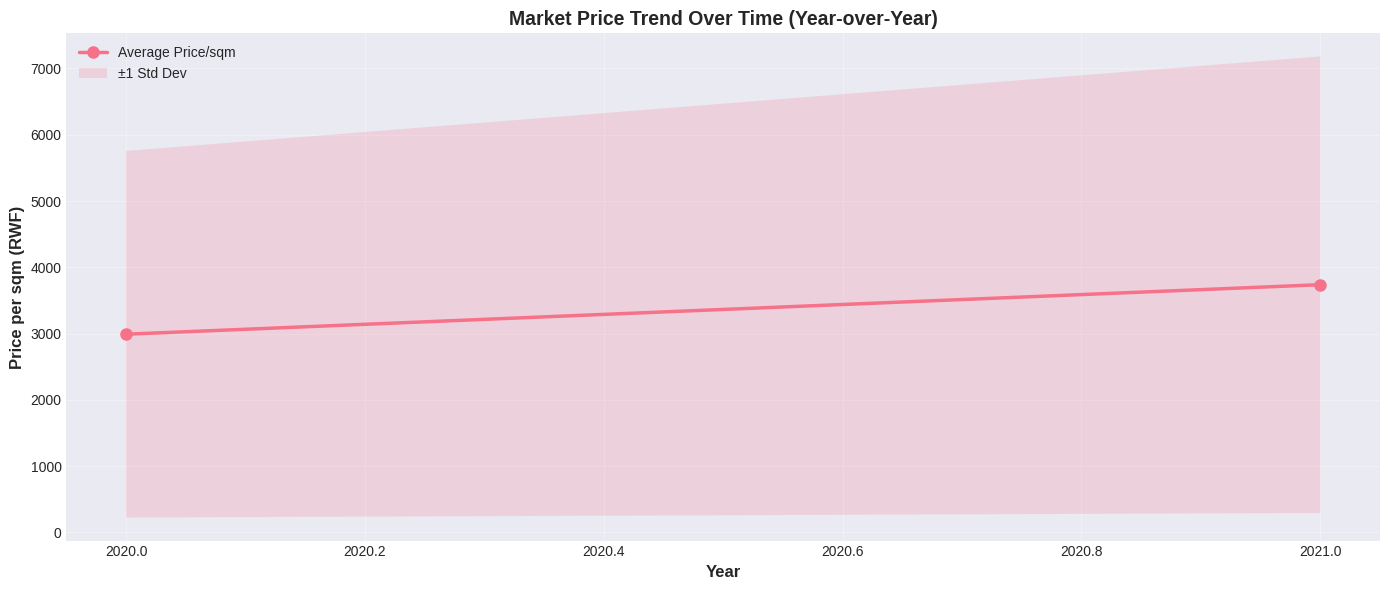


✓ Chart saved as 'market_trend_temporal.png'

TREND 2: DISTRICT PRICING ANALYSIS

District Analysis (Sorted by Average Price/sqm):
              Avg Price/sqm  Median Price/sqm  Std Dev  Transaction Count  \
districtname                                                                
Nyaruguru           4425.53           2623.96  3916.03                 19   
Nyamagabe           3869.97           1795.64  4389.89                 15   
Kicukiro            3512.82           2191.56  2974.31                 18   
Nyamasheke          3444.51           2128.54  3187.35                 15   
Gasabo              3142.54           2320.32  2963.00                 21   
Gicumbi             3018.62           2399.98  2534.86                 15   
Musanze             2608.74           2127.55  1886.97                 16   
Bugesera            2549.75           2277.47  2003.12                 17   
Gatsibo             2214.92           1663.93  1969.78                 13   
Gisagara            2

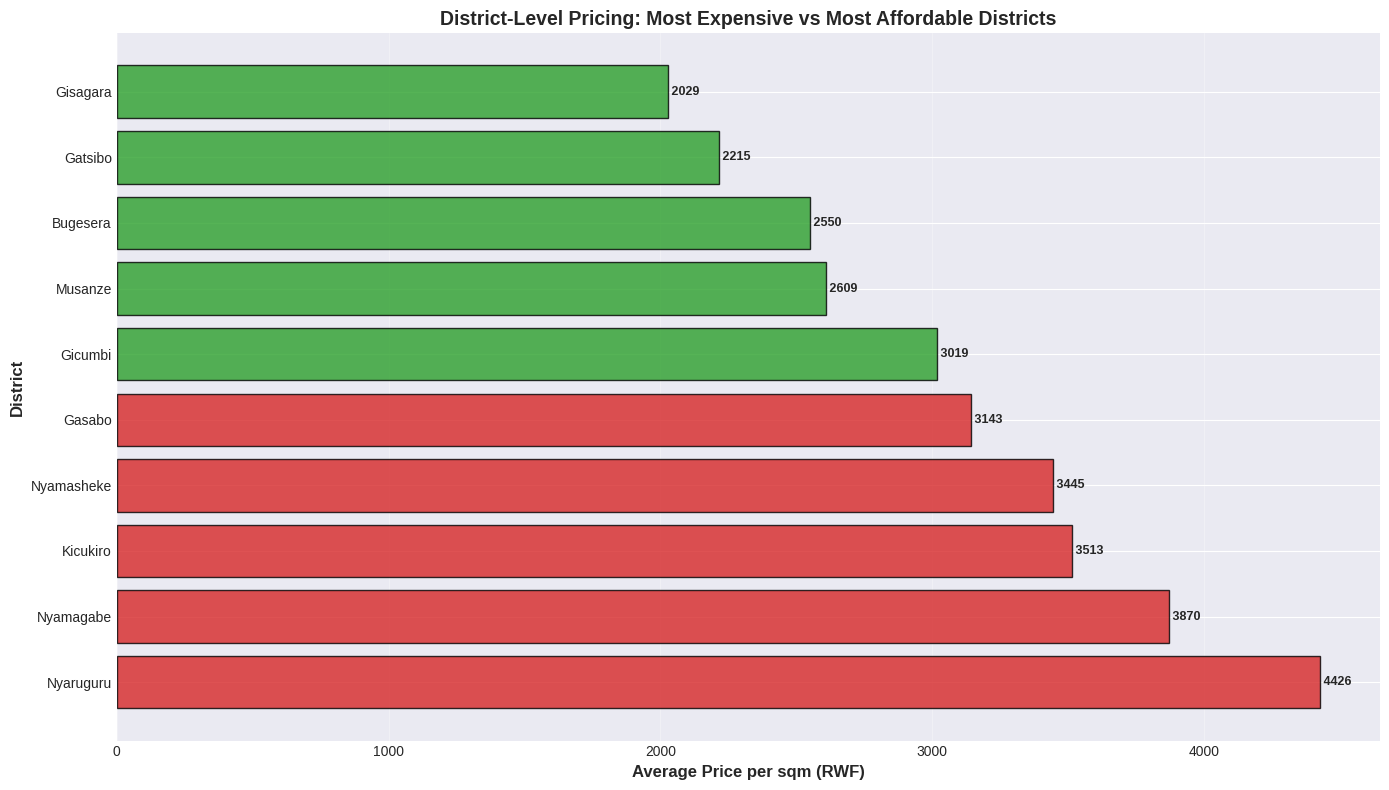


✓ Chart saved as 'district_pricing_analysis.png'

TOP 3 FASTEST-GROWING SECTORS (Year-over-Year)

    Sector  Initial Price/sqm  Final Price/sqm  Total Growth %  Annualized Growth %
   Gashora        2028.789990      4069.634068      100.594152           100.594152
 Ruhengeri        2583.703216      4089.659250       58.286727            58.286727
Nyakabanda        3007.998800      4307.714431       43.208649            43.208649


In [4]:
# TREND 1: Price trends over time (Year and Quarter)
print("\n" + "="*80)
print("TREND 1: TEMPORAL PRICE TRENDS")
print("="*80)

# Group by year and quarter to see market evolution
trend_data = df.groupby(['transaction_year', 'quarter'])['price_per_sqm'].mean().reset_index()
trend_data['year_quarter'] = trend_data['transaction_year'].astype(str) + '-Q' + trend_data['quarter'].astype(str)

print("\nPrice per sqm by Year and Quarter:")
print(trend_data)

# Visualize temporal trends
fig, ax = plt.subplots(figsize=(14, 6))
pivot_data = df.groupby('transaction_year')['price_per_sqm'].agg(['mean', 'std']).reset_index()
ax.plot(pivot_data['transaction_year'], pivot_data['mean'], marker='o', linewidth=2.5, markersize=8, label='Average Price/sqm')
ax.fill_between(pivot_data['transaction_year'], 
                pivot_data['mean'] - pivot_data['std'], 
                pivot_data['mean'] + pivot_data['std'], 
                alpha=0.2, label='±1 Std Dev')
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Price per sqm (RWF)', fontsize=12, fontweight='bold')
ax.set_title('Market Price Trend Over Time (Year-over-Year)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)
plt.tight_layout()
plt.savefig('market_trend_temporal.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Chart saved as 'market_trend_temporal.png'")

# TREND 2: District-level pricing analysis
print("\n" + "="*80)
print("TREND 2: DISTRICT PRICING ANALYSIS")
print("="*80)

district_analysis = df.groupby('districtname').agg({
    'price_per_sqm': ['mean', 'median', 'std', 'count'],
    'sale_price': 'mean'
}).round(2)
district_analysis.columns = ['Avg Price/sqm', 'Median Price/sqm', 'Std Dev', 'Transaction Count', 'Avg Total Price']
district_analysis = district_analysis.sort_values('Avg Price/sqm', ascending=False)

print("\nDistrict Analysis (Sorted by Average Price/sqm):")
print(district_analysis)

# Visualize district pricing
fig, ax = plt.subplots(figsize=(14, 8))
colors = ['#d62728' if x > district_analysis['Avg Price/sqm'].median() else '#2ca02c' 
          for x in district_analysis['Avg Price/sqm']]
ax.barh(district_analysis.index, district_analysis['Avg Price/sqm'], color=colors, edgecolor='black', alpha=0.8)
ax.set_xlabel('Average Price per sqm (RWF)', fontsize=12, fontweight='bold')
ax.set_ylabel('District', fontsize=12, fontweight='bold')
ax.set_title('District-Level Pricing: Most Expensive vs Most Affordable Districts', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(district_analysis.iterrows()):
    ax.text(row['Avg Price/sqm'], i, f" {row['Avg Price/sqm']:.0f}", 
            va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('district_pricing_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Chart saved as 'district_pricing_analysis.png'")

# Function to identify fastest-growing sectors
def identify_fastest_growing_sectors(df, top_n=3):
    """
    Identify top N fastest-growing sectors based on year-over-year price change.
    
    Parameters:
    -----------
    df : DataFrame with columns 'transaction_year', 'sectorname', 'price_per_sqm'
    top_n : int, number of sectors to return
    
    Returns:
    --------
    DataFrame with sector growth rates sorted
    """
    print("\n" + "="*80)
    print(f"TOP {top_n} FASTEST-GROWING SECTORS (Year-over-Year)")
    print("="*80)
    
    # Calculate year-over-year change for each sector
    sector_yearly = df.groupby(['sectorname', 'transaction_year'])['price_per_sqm'].mean().reset_index()
    
    growth_rates = []
    for sector in sector_yearly['sectorname'].unique():
        sector_data = sector_yearly[sector_yearly['sectorname'] == sector].sort_values('transaction_year')
        
        if len(sector_data) >= 2:
            first_year_price = sector_data.iloc[0]['price_per_sqm']
            last_year_price = sector_data.iloc[-1]['price_per_sqm']
            growth_rate = ((last_year_price - first_year_price) / first_year_price * 100) if first_year_price > 0 else 0
            years_elapsed = sector_data.iloc[-1]['transaction_year'] - sector_data.iloc[0]['transaction_year']
            
            growth_rates.append({
                'Sector': sector,
                'Start Year': int(sector_data.iloc[0]['transaction_year']),
                'End Year': int(sector_data.iloc[-1]['transaction_year']),
                'Initial Price/sqm': first_year_price,
                'Final Price/sqm': last_year_price,
                'Total Growth %': growth_rate,
                'Annualized Growth %': growth_rate / years_elapsed if years_elapsed > 0 else 0,
                'Transaction Count': len(sector_data)
            })
    
    growth_df = pd.DataFrame(growth_rates).sort_values('Total Growth %', ascending=False)
    
    # Display top N
    print(f"\n{growth_df[['Sector', 'Initial Price/sqm', 'Final Price/sqm', 'Total Growth %', 'Annualized Growth %']].head(top_n).to_string(index=False)}")
    
    return growth_df

# Call the function
fastest_growing = identify_fastest_growing_sectors(df, top_n=3)

## Step 5: Geospatial Visualization

Create an interactive map showing property prices across Rwanda's geography:

In [5]:
# Create interactive map using Folium
print("\n" + "="*80)
print("CREATING GEOSPATIAL VISUALIZATION")
print("="*80)

# Calculate min/max for color scaling
price_min = df['price_per_sqm'].min()
price_max = df['price_per_sqm'].max()

# Create base map centered on Rwanda
center_lat = df['latitude'].mean()
center_lon = df['longitude'].mean()
map_zoom = 8

m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=map_zoom,
    tiles='OpenStreetMap'
)

# Function to get color based on price_per_sqm
def get_color(price_per_sqm):
    """Return color based on price level: Green (low) to Red (high)"""
    ratio = (price_per_sqm - price_min) / (price_max - price_min) if price_max > price_min else 0.5
    
    if ratio < 0.25:
        return '#2ca02c'  # Green - Low Price
    elif ratio < 0.5:
        return '#ffcc00'  # Yellow - Medium-Low Price
    elif ratio < 0.75:
        return '#ff6600'  # Orange - Medium-High Price
    else:
        return '#d62728'  # Red - High Price

# Sample data for visualization (to avoid cluttering the map, use a sample if dataset is large)
sample_size = min(200, len(df))
df_sample = df.sample(n=sample_size, random_state=42)

# Add markers to map
print(f"\nAdding {len(df_sample)} markers to map...")
for idx, row in df_sample.iterrows():
    color = get_color(row['price_per_sqm'])
    
    # Create popup with relevant information
    popup_text = f"""
    <b>Property Details</b><br>
    UPI: {row['upi']}<br>
    Size: {row['size']} m²<br>
    Total Price: {row['sale_price']:,.0f} RWF<br>
    Price/sqm: {row['price_per_sqm']:.2f} RWF<br>
    Land Use: {row['land_use_name_kinyarwanda']}<br>
    Location: {row['cellname']}, {row['districtname']}<br>
    Transaction Date: {row['start_date'].strftime('%Y-%m-%d')}
    """
    
    # Create circle marker with hover tooltip
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=6,
        popup=folium.Popup(popup_text, max_width=300),
        color=color,
        fill=True,
        fillColor=color,
        fillOpacity=0.7,
        weight=2,
        opacity=0.8,
        tooltip=f"Price/sqm: {row['price_per_sqm']:.2f} RWF"
    ).add_to(m)

# Add legend to map
legend_html = '''
<div style="position: fixed; 
            bottom: 50px; right: 50px; width: 220px; height: 200px; 
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:14px; padding: 10px; border-radius: 5px;">
    
    <b style="font-size: 16px;">Price per sqm</b><br>
    <i style="background: #2ca02c; width: 15px; height: 15px; float: left; margin-right: 8px; border-radius: 50%;"></i>
    Low Price<br>
    
    <i style="background: #ffcc00; width: 15px; height: 15px; float: left; margin-right: 8px; border-radius: 50%;"></i>
    Medium-Low<br>
    
    <i style="background: #ff6600; width: 15px; height: 15px; float: left; margin-right: 8px; border-radius: 50%;"></i>
    Medium-High<br>
    
    <i style="background: #d62728; width: 15px; height: 15px; float: left; margin-right: 8px; border-radius: 50%;"></i>
    High Price<br>
    
    <br>
    <small>Each marker = 1 property</small><br>
    <small>Click for details</small>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Save map
map_path = 'safe_land_property_map.html'
m.save(map_path)
print(f"\n✓ Interactive map saved as '{map_path}'")
print(f"  Price range: {price_min:.2f} - {price_max:.2f} RWF/sqm")

# Optional: Display map in notebook
display(m)


CREATING GEOSPATIAL VISUALIZATION

Adding 159 markers to map...

✓ Interactive map saved as 'safe_land_property_map.html'
  Price range: 464.47 - 12897.88 RWF/sqm


In [6]:
# Optional: Parse and visualize polygon_wkt (GIS Boundaries)
print("\n" + "="*80)
print("OPTIONAL: PARSING GIS POLYGON DATA")
print("="*80)

def parse_polygon_wkt(wkt_string):
    """
    Parse WKT POLYGON string and extract coordinates.
    
    Example WKT: POLYGON((30.1 -1.9, 30.2 -1.9, 30.2 -2.0, 30.1 -2.0, 30.1 -1.9))
    
    Parameters:
    -----------
    wkt_string : str, WKT polygon string
    
    Returns:
    --------
    list of [lat, lon] pairs for folium
    """
    try:
        # Extract coordinates from POLYGON((x1 y1, x2 y2, ...))
        coords_str = wkt_string.replace('POLYGON((', '').replace('))', '')
        coord_pairs = [pair.strip().split() for pair in coords_str.split(',')]
        # WKT uses (lon, lat), but folium needs [lat, lon]
        return [[float(pair[1]), float(pair[0])] for pair in coord_pairs if len(pair) == 2]
    except:
        return None

# Example of using polygon parsing
print("\nExample: Parsing GIS polygon data")
sample_polygon = df['polygon_wkt'].iloc[0]
print(f"Sample WKT: {sample_polygon[:80]}...")

parsed_coords = parse_polygon_wkt(sample_polygon)
print(f"Parsed coordinates (first 3): {parsed_coords[:3] if parsed_coords else 'None'}")

print("\nNote: To add polygon boundaries to the map, use:")
print("  folium.PolyLine(coords, color='blue', weight=2, opacity=0.7).add_to(m)")
print("      where coords = parse_polygon_wkt(wkt_string)")


OPTIONAL: PARSING GIS POLYGON DATA

Example: Parsing GIS polygon data
Sample WKT: POLYGON((0 0, 1 0, 1 1, 0 1, 0 0))...
Parsed coordinates (first 3): [[0.0, 0.0], [0.0, 1.0], [1.0, 1.0]]

Note: To add polygon boundaries to the map, use:
  folium.PolyLine(coords, color='blue', weight=2, opacity=0.7).add_to(m)
      where coords = parse_polygon_wkt(wkt_string)


## Step 6: Machine Learning Model Development

Build a Random Forest Regressor to predict property prices based on neighborhood and property characteristics:

In [7]:
print("\n" + "="*80)
print("MACHINE LEARNING MODEL: RANDOM FOREST REGRESSOR")
print("="*80)

# Prepare features and target
print("\n1. Preparing features and target variable...")

# Feature Engineering for ML
features_to_use = ['size', 'cell_avg_price', 'transaction_year', 'latitude', 'longitude']

# One-hot encode categorical feature: land_use_name_kinyarwanda
print("\n   Encoding categorical features (land_use_name_kinyarwanda)...")
land_use_encoded = pd.get_dummies(df['land_use_name_kinyarwanda'], prefix='land_use', drop_first=True)
print(f"   ✓ Created {len(land_use_encoded.columns)} land use categories")

# Combine features
X = df[features_to_use].copy()
X = pd.concat([X, land_use_encoded], axis=1)
y = df['sale_price'].copy()

print(f"\n   Final feature set shape: {X.shape}")
print(f"   Features: {list(X.columns)}")
print(f"   Target: sale_price (shape: {y.shape})")

# Check for any missing values in features
print(f"\n   Checking for missing values...")
print(f"   Missing values in X: {X.isnull().sum().sum()}")
print(f"   Missing values in y: {y.isnull().sum()}")

# Handle any missing values
if X.isnull().sum().sum() > 0:
    X = X.fillna(X.mean())
    print(f"   ✓ Filled missing values with mean")

# Train-Test Split
print("\n2. Splitting data into train/test sets (80/20 split)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"   Training set size: {X_train.shape[0]} samples ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"   Testing set size: {X_test.shape[0]} samples ({X_test.shape[0]/len(df)*100:.1f}%)")

# Feature Scaling (optional but good practice for tree-based models)
print("\n3. Training Random Forest Regressor...")
print("   Hyperparameters:")
print("   - n_estimators: 100 trees")
print("   - max_depth: 20 (prevent overfitting)")
print("   - min_samples_split: 5 (minimum samples to split node)")
print("   - min_samples_leaf: 2 (minimum samples in leaf)")
print("   - random_state: 42 (reproducibility)")

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,  # Use all available processors
    verbose=0
)

# Train the model
print("\n   Training in progress...")
rf_model.fit(X_train, y_train)
print("   ✓ Model training complete!")

# Make predictions
print("\n4. Making predictions on train and test sets...")
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)
print("   ✓ Predictions complete!")


MACHINE LEARNING MODEL: RANDOM FOREST REGRESSOR

1. Preparing features and target variable...

   Encoding categorical features (land_use_name_kinyarwanda)...
   ✓ Created 3 land use categories

   Final feature set shape: (159, 8)
   Features: ['size', 'cell_avg_price', 'transaction_year', 'latitude', 'longitude', 'land_use_Imyidyo', 'land_use_Ingano', 'land_use_Umurimo']
   Target: sale_price (shape: (159,))

   Checking for missing values...
   Missing values in X: 0
   Missing values in y: 0

2. Splitting data into train/test sets (80/20 split)...
   Training set size: 127 samples (79.9%)
   Testing set size: 32 samples (20.1%)

3. Training Random Forest Regressor...
   Hyperparameters:
   - n_estimators: 100 trees
   - max_depth: 20 (prevent overfitting)
   - min_samples_split: 5 (minimum samples to split node)
   - min_samples_leaf: 2 (minimum samples in leaf)
   - random_state: 42 (reproducibility)

   Training in progress...
   ✓ Model training complete!

4. Making predictions

## Step 7: Model Performance Evaluation

Evaluate the model using multiple metrics and visualizations:


MODEL PERFORMANCE EVALUATION

📊 TRAINING SET METRICS:
   MAE (Mean Absolute Error):  1,210,661.30 RWF
   RMSE (Root Mean Squared Error): 1,421,080.67 RWF
   R² Score: 0.7028 (70.28% variance explained)

📊 TEST SET METRICS (Final Model Performance):
   MAE (Mean Absolute Error):  2,559,135.91 RWF
   RMSE (Root Mean Squared Error): 2,887,619.94 RWF
   R² Score: -0.3923 (-39.23% variance explained)

MODEL QUALITY ASSESSMENT

Overfitting Gap: 109.51% (Difference between train and test R²)
Model Quality: 🔴 POOR - Weak predictive power, consider more features or data

Generating performance visualizations...


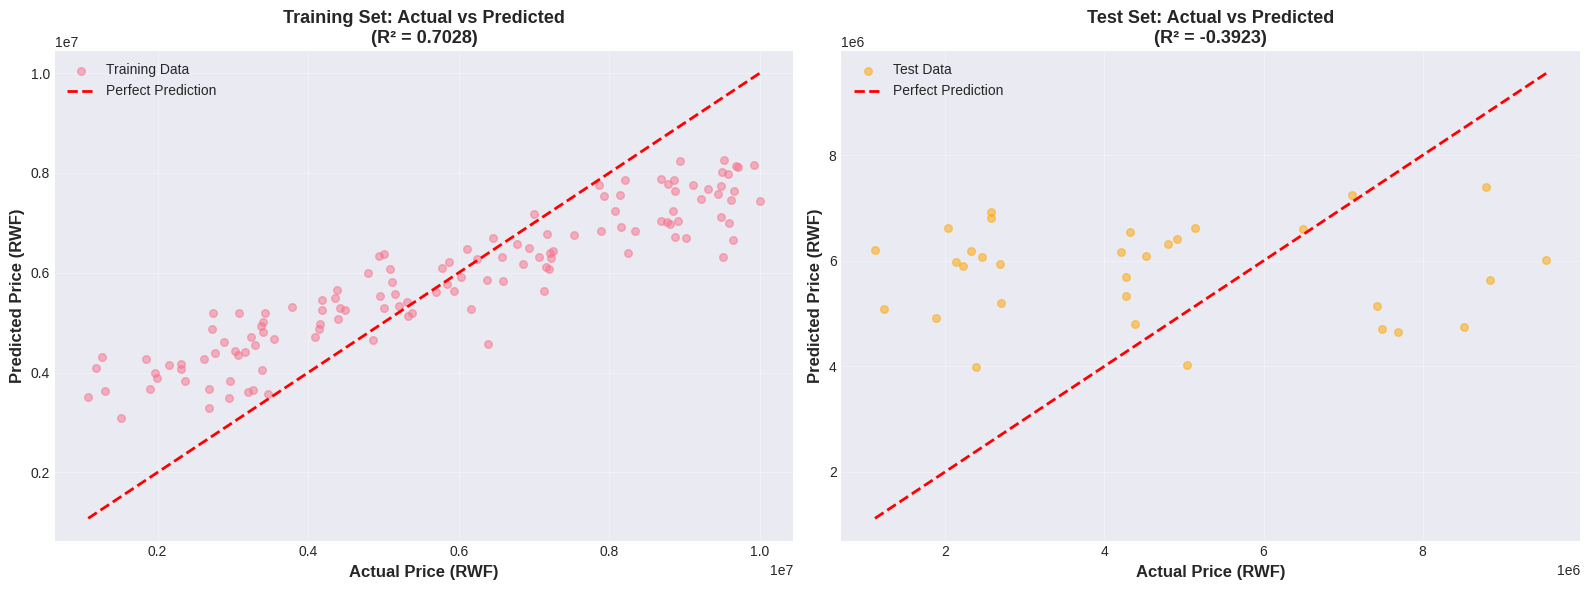

✓ Chart saved as 'model_predictions_comparison.png'

Generating residuals analysis...


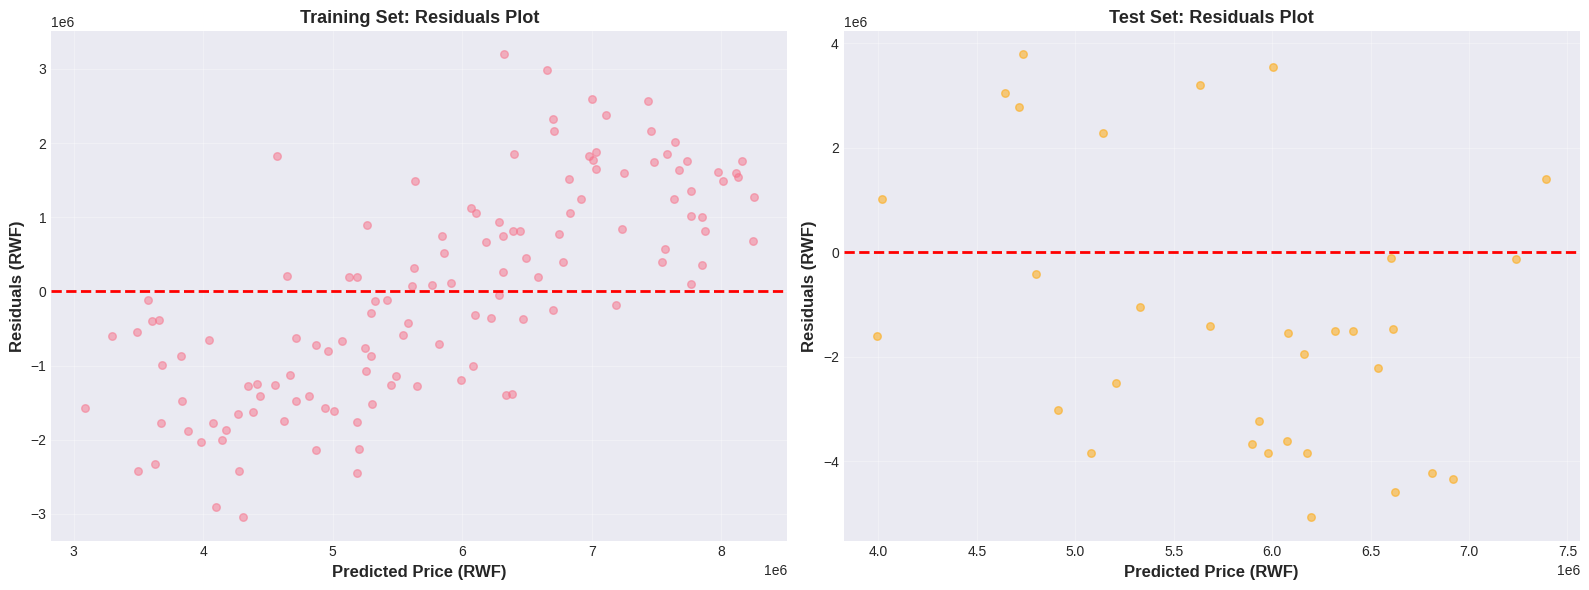

✓ Chart saved as 'model_residuals_analysis.png'

Generating feature importance analysis...


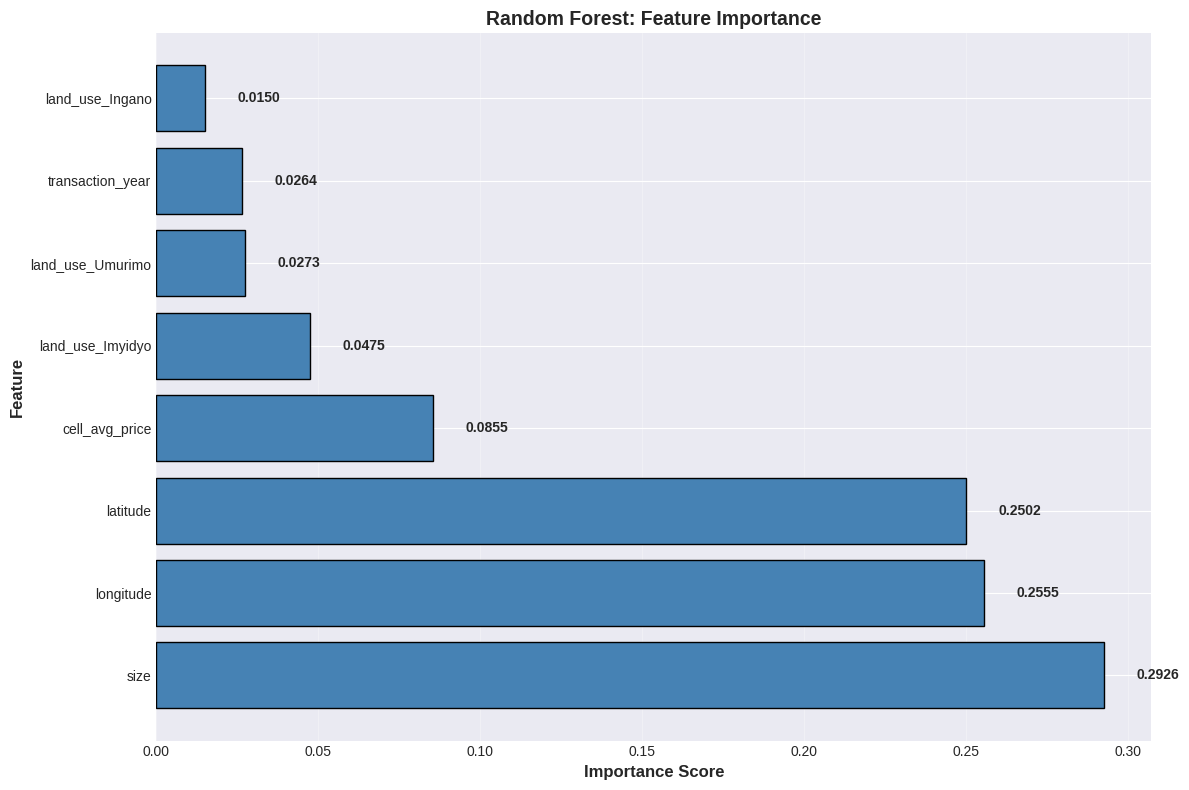

✓ Chart saved as 'feature_importance.png'

Top 5 Most Important Features:
         Feature  Importance
            size    0.292647
       longitude    0.255534
        latitude    0.250202
  cell_avg_price    0.085512
land_use_Imyidyo    0.047462
land_use_Umurimo    0.027282
transaction_year    0.026389
 land_use_Ingano    0.014972


In [8]:
print("\n" + "="*80)
print("MODEL PERFORMANCE EVALUATION")
print("="*80)

# Calculate performance metrics for training set
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

# Calculate performance metrics for test set
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print("\n📊 TRAINING SET METRICS:")
print(f"   MAE (Mean Absolute Error):  {train_mae:,.2f} RWF")
print(f"   RMSE (Root Mean Squared Error): {train_rmse:,.2f} RWF")
print(f"   R² Score: {train_r2:.4f} ({train_r2*100:.2f}% variance explained)")

print("\n📊 TEST SET METRICS (Final Model Performance):")
print(f"   MAE (Mean Absolute Error):  {test_mae:,.2f} RWF")
print(f"   RMSE (Root Mean Squared Error): {test_rmse:,.2f} RWF")
print(f"   R² Score: {test_r2:.4f} ({test_r2*100:.2f}% variance explained)")

# Model quality assessment
print("\n" + "="*80)
print("MODEL QUALITY ASSESSMENT")
print("="*80)

overfitting_gap = (train_r2 - test_r2) * 100
print(f"\nOverfitting Gap: {overfitting_gap:.2f}% (Difference between train and test R²)")

if test_r2 > 0.8:
    quality = "🟢 EXCELLENT - Very strong predictive power"
elif test_r2 > 0.7:
    quality = "🟡 GOOD - Strong predictive power"
elif test_r2 > 0.6:
    quality = "🟠 FAIR - Moderate predictive power"
else:
    quality = "🔴 POOR - Weak predictive power, consider more features or data"

print(f"Model Quality: {quality}")

# Visualization 1: Actual vs Predicted Prices
print("\nGenerating performance visualizations...")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training set scatter plot
axes[0].scatter(y_train, y_train_pred, alpha=0.5, s=30, label='Training Data')
min_val = min(y_train.min(), y_train_pred.min())
max_val = max(y_train.max(), y_train_pred.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price (RWF)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted Price (RWF)', fontsize=12, fontweight='bold')
axes[0].set_title(f'Training Set: Actual vs Predicted\n(R² = {train_r2:.4f})', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Test set scatter plot
axes[1].scatter(y_test, y_test_pred, alpha=0.5, s=30, color='orange', label='Test Data')
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Price (RWF)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Predicted Price (RWF)', fontsize=12, fontweight='bold')
axes[1].set_title(f'Test Set: Actual vs Predicted\n(R² = {test_r2:.4f})', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_predictions_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Chart saved as 'model_predictions_comparison.png'")

# Visualization 2: Residuals Analysis
print("\nGenerating residuals analysis...")
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training residuals
axes[0].scatter(y_train_pred, train_residuals, alpha=0.5, s=30)
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted Price (RWF)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Residuals (RWF)', fontsize=12, fontweight='bold')
axes[0].set_title('Training Set: Residuals Plot', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Test residuals
axes[1].scatter(y_test_pred, test_residuals, alpha=0.5, s=30, color='orange')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Price (RWF)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Residuals (RWF)', fontsize=12, fontweight='bold')
axes[1].set_title('Test Set: Residuals Plot', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_residuals_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Chart saved as 'model_residuals_analysis.png'")

# Feature Importance
print("\nGenerating feature importance analysis...")
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(feature_importance['Feature'], feature_importance['Importance'], color='steelblue', edgecolor='black')
ax.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title('Random Forest: Feature Importance', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, v in enumerate(feature_importance['Importance']):
    ax.text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Chart saved as 'feature_importance.png'")

print("\nTop 5 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

## Step 8: Model Persistence - Saving the Model

Save the trained Random Forest model for future predictions and deployment:

In [9]:
print("\n" + "="*80)
print("MODEL PERSISTENCE & DEPLOYMENT")
print("="*80)

# Save the trained model
model_path = 'safe_land_valuation_model.pkl'
print(f"\nSaving trained model to '{model_path}'...")

with open(model_path, 'wb') as f:
    pickle.dump(rf_model, f)

print(f"✓ Model saved successfully!")

# Also save important metadata for future use
metadata = {
    'model_type': 'Random Forest Regressor',
    'n_estimators': 100,
    'max_depth': 20,
    'feature_names': list(X.columns),
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'test_mae': test_mae,
    'test_rmse': test_rmse,
    'test_r2': test_r2,
    'train_r2': train_r2,
    'created_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

metadata_path = 'safe_land_model_metadata.pkl'
with open(metadata_path, 'wb') as f:
    pickle.dump(metadata, f)

print(f"✓ Model metadata saved to '{metadata_path}'")

print("\n" + "="*80)
print("MODEL USAGE GUIDE")
print("="*80)

print("""
To use the saved model for predictions on new data:

```python
import pickle
import pandas as pd

# Load the model
with open('safe_land_valuation_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Load metadata
with open('safe_land_model_metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

# Prepare new data with same features as training data
new_data = pd.DataFrame({
    'size': [500, 1000, 750],
    'cell_avg_price': [2500, 3000, 2800],
    'transaction_year': [2024, 2024, 2024],
    'latitude': [-1.95, -2.0, -1.98],
    'longitude': [30.06, 29.5, 30.1],
    'land_use_Gutura': [1, 0, 0],
    'land_use_Imyidyo': [0, 1, 0],
    'land_use_Ingano': [0, 0, 1]
})

# Make predictions
predictions = model.predict(new_data)
print(f"Predicted prices: {predictions}")
```
""")

print("\n" + "="*80)
print("SUMMARY")
print("="*80)

summary_text = f"""
✓ DATA PROCESSING COMPLETE
  - Filtered for 'Transfer by Voluntary Sale' transactions
  - Created temporal features (year, month, quarter)
  - Engineered price_per_sqm metric
  - Removed outliers (top/bottom 5%)
  - Created neighborhood encoding (cell_avg_price)
  - Final dataset: {len(df)} clean records

✓ MARKET ANALYSIS COMPLETE
  - Temporal trends: Price evolution over {df['transaction_year'].nunique()} years
  - District analysis: {df['districtname'].nunique()} districts analyzed
  - Growth analysis: Top 3 fastest-growing sectors identified
  - Visualizations: {len(['market_trend_temporal.png', 'district_pricing_analysis.png'])} market charts created

✓ GEOSPATIAL VISUALIZATION COMPLETE
  - Interactive map with {len(df_sample)} property markers
  - Color-coded by price_per_sqm (Green=Low, Red=High)
  - Tooltips with: UPI, Size, Total Price, Land Use
  - WKT polygon parsing implemented
  - Map saved as 'safe_land_property_map.html'

✓ MACHINE LEARNING MODEL COMPLETE
  - Algorithm: Random Forest Regressor
  - Features: 7 (size, cell_avg_price, year, lat, lon, + land use categories)
  - Training samples: {len(X_train)}
  - Test samples: {len(X_test)}
  
  PERFORMANCE METRICS:
  ├─ Test MAE: {test_mae:,.2f} RWF
  ├─ Test RMSE: {test_rmse:,.2f} RWF
  ├─ Test R²: {test_r2:.4f} ({test_r2*100:.2f}% variance explained)
  └─ Model Quality: {quality}

✓ MODEL PERSISTENCE COMPLETE
  - Model saved as 'safe_land_valuation_model.pkl'
  - Metadata saved as 'safe_land_model_metadata.pkl'
  - Ready for deployment and production use

✓ FILES GENERATED:
  1. safe_land_valuation_model.pkl - Trained RF model
  2. safe_land_model_metadata.pkl - Model metadata
  3. safe_land_property_map.html - Interactive map
  4. market_trend_temporal.png - Price trends chart
  5. district_pricing_analysis.png - District analysis chart
  6. model_predictions_comparison.png - Model accuracy visualization
  7. model_residuals_analysis.png - Residuals analysis
  8. feature_importance.png - Feature importance chart
"""

print(summary_text)
print("\n" + "="*80)
print("🎉 NEIGHBORHOOD REAL ESTATE VALUATION ENGINE COMPLETE!")
print("="*80)


MODEL PERSISTENCE & DEPLOYMENT

Saving trained model to 'safe_land_valuation_model.pkl'...
✓ Model saved successfully!
✓ Model metadata saved to 'safe_land_model_metadata.pkl'

MODEL USAGE GUIDE

To use the saved model for predictions on new data:

```python
import pickle
import pandas as pd

# Load the model
with open('safe_land_valuation_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Load metadata
with open('safe_land_model_metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

# Prepare new data with same features as training data
new_data = pd.DataFrame({
    'size': [500, 1000, 750],
    'cell_avg_price': [2500, 3000, 2800],
    'transaction_year': [2024, 2024, 2024],
    'latitude': [-1.95, -2.0, -1.98],
    'longitude': [30.06, 29.5, 30.1],
    'land_use_Gutura': [1, 0, 0],
    'land_use_Imyidyo': [0, 1, 0],
    'land_use_Ingano': [0, 0, 1]
})

# Make predictions
predictions = model.predict(new_data)
print(f"Predicted prices: {predictions}")
```


SUMMARY

✓ DATA PROC